## Win/Loss Betting Model


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, bernoulli
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from spcl_case import *
plt.style.use('fivethirtyeight')

Obtain results of teams within the past year

In [2]:
h_matches = pd.read_csv('hltv_csv/matchResults.csv')
h_matches['Date'] = pd.to_datetime(h_matches['Date'])
h_teams = pd.read_csv('hltv_csv/teams_w_ranking.csv')
h_teams = fix_teams(h_teams.set_index('ID'))

In [3]:
MIN_DATE = dt.datetime(2016,7,1)
EVENT_SET = 'eslpl'
FILTER_TEAMS = {'eslpl': ['OpTic', 'SK', 'Cloud9', 'Liquid', 'Luminosity', 'Misfits', 'Renegades', 'Immortals', 
                    'Splyce', 'compLexity', 'Rogue', 'Ghost', 'CLG', 'NRG', 'FaZe', 'North',
                    'BIG', 'LDLC', 'mousesports', 'EnVyUs', 'NiP', 'Virtus.pro', 
                    'Astralis', 'G2', 'GODSENT', 'Heroic', 'fnatic', 'NiP', 'Heroic'],
                'mdleu': ['Virtus.pro', 'FlipSid3', 'eXtatus', 'AGO', 'Fragsters', 'Gambit', 'PRIDE', '1337HUANIA', 
                    'VITALIS', 'Epsilon', 'CHAOS', 'Crowns', 'MK', 'Japaleno', 'Not Academy', 'aAa', 'Space Soldiers',
                    'Singularity', 'Nexus', 'Invictus Aquilas', 'Spirit', 'Kinguin', 'Seed', 'Endpoint', 'iGame.com', 'TEAM5',
                    'ALTERNATE aTTaX'],
                'mdlna': ['Gale Force', 'FRENCH CANADIANS', 'Mythic', 'GX', 'Beacon', 'Torqued', 'Rise Nation', 'Denial', 'subtLe', 
                   'SoaR', 'Muffin Lightning', 'Iceberg', 'ex-Nitrious', 'Adaptation', 'Morior Invictus', 'Naventic', 'CheckSix', 'Good People'
                   , 'LFAO', 'CLG Academy', 'Ambition', 'Mostly Harmless', 'Gorilla Core', 'ex-Nitrious', 'ANTI ECO'],
                'mdlau': ['Grayhound', 'Tainted Minds', 'Kings', 'Chiefs', 'Dark Sided', 'seadoggs', 'Athletico', 'Legacy',
                    'SIN', 'Noxide', 'Control', 'SYF', 'Corvidae', 'Funkd', 'Masterminds', 'Conspiracy', 'AVANT']
               }

h_matches = h_matches[h_matches['Date'] >= MIN_DATE]
h_filter_teams = h_teams[h_teams['Name'].isin(FILTER_TEAMS[EVENT_SET])]
h_matches = h_matches[h_matches['Team 1 ID'].isin(h_filter_teams.index) | h_matches['Team 2 ID'].isin(h_filter_teams.index)]
h_matches['winner'] = h_matches.apply(lambda x: x['Team 1 ID'] if x['Team 1 Score'] > x['Team 2 Score'] else x['Team 2 ID'], axis=1)
h_matches['score_diff'] = h_matches['Team 1 Score'] - h_matches['Team 2 Score']

In [4]:
obs = h_matches[['Date', 'Map', 'Team 1 ID', 'Team 2 ID', 'score_diff', 'winner']]
obs = obs[obs.Map != 'Default']
obs.Date = obs.Date.dt.to_period('M') # date period
obs = obs.sort_values('Date')
obs.head()

,Date,Map,Team 1 ID,Team 2 ID,score_diff,winner
17401,2016-07,Cache,4674,4559,2,4674
17757,2016-07,Overpass,5752,6736,3,5752
17733,2016-07,Train,6736,5005,10,6736
17732,2016-07,Overpass,6736,5005,7,6736
17721,2016-07,Cobblestone,5752,6792,2,5752


In [11]:
teams = np.sort(np.unique(np.concatenate([h_matches['Team 1 ID'], h_matches['Team 2 ID']])))
maps = obs.Map.unique()
periods = obs.Date.unique()
tmap = {v:k for k,v in dict(enumerate(teams)).items()}
mmap = {v:k for k,v in dict(enumerate(maps)).items()}
pmap = {v:k for k,v in dict(enumerate(periods)).items()}
n_teams = len(teams)
n_maps = len(maps)
n_periods = len(periods)
print('Number of Teams: %i ' % n_teams)
print('Number of Filtered Teams: %i' % len(FILTER_TEAMS[EVENT_SET]))
print('Number of Matches: %i ' % len(h_matches))
print('Number of Maps: %i '% n_maps)
print('Number of Periods: %i '% n_periods)

Number of Teams: 288 
Number of Filtered Teams: 29
Number of Matches: 5763 
Number of Maps: 8 
Number of Periods: 17 


## Pymc Model

Determining Binary Win Loss: $wl_{m,i,j}$
$$
\omega, \tau, \sim HC(0.5) \\
R_{k} \sim N(0, \omega^2) \\
\tilde{\theta}_{m,k} \sim N(0,1) \\
R_{m,k} = R_{k} + \tau\tilde{\theta} \\
wl_{m,i,j} \sim B(p = \text{Sig}(R_{m,i}-R_{m,j})) \\
$$

and score difference: $sc_{m,i,j}$

$$
\alpha \sim Gamma(10,5) \\
\kappa_{m,i,j} = 32\text{Sig}(\alpha(R_{m,i}-R_{m,j}))-16 \\
\sigma_{m} \sim HC(0.5) \\
sc_{m,i,j} \sim N(\kappa, \sigma_{m}^2)
$$

In [12]:
import pymc3 as pm
import theano
import theano.tensor as tt

In [13]:
obs_map = obs['Map'].map(mmap).values
obs_team_1 = obs['Team 1 ID'].map(tmap).values
obs_team_2 = obs['Team 2 ID'].map(tmap).values
obs_period = obs['Date'].map(pmap).values

In [29]:
a = np.arange(1,n_periods)
with pm.Model() as rating_model:
    
    rho = pm.Normal('rho', 1, 0.5)
    sigma = pm.HalfCauchy('sigma', 0.5, shape=n_teams)
    time_rating = [pm.Normal('rating_0', 0, 1, shape=n_teams)]
    for i in a:
        time_rating.append(pm.Normal('rating_'+str(i), rho*time_rating[i-1], sigma, shape=n_teams))
        
    diff = [time_rating[i][obs_team_1[obs_period == i]] - time_rating[i][obs_team_2[obs_period == i]] for i in range(n_periods)]
    diff = tt.concatenate(diff)
    p = 0.5*pm.math.tanh(diff)+0.5
    #alpha = 0.3485
    #kappa = 16.*pm.math.tanh(alpha*diff)
    
    #sc = pm.Normal('observed score diff', kappa, 0.5, observed=obs['score_diff'])
    wl = pm.Bernoulli('observed wl', p=p, observed=(obs['Team 1 ID'] == obs['winner']).values)

In [30]:
# help my models too slow and i am bad at coding, pls just approximate :3
with rating_model:
    approx = pm.fit(40000, method='nfvi')
    ap_trace = approx.sample(1000)

Average Loss = 4,564.4: 100%|███████████████████████████████████████████████████| 20000/20000 [01:43<00:00, 192.56it/s]
Finished [100%]: Average Loss = 4,564.7


In [20]:
with rating_model:
    trace = pm.sample(1000, init='jitter+adapt_diag', n_init=20000, tune=250, nuts_kwargs={'target_accept': 0.9, 'max_treedepth': 15}) # tune=1000, nuts_kwargs={'target_accept': 0.95}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 19%|██████████████▌                                                              | 237/1250 [24:41<1:45:30,  6.25s/it]C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:429: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:431: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



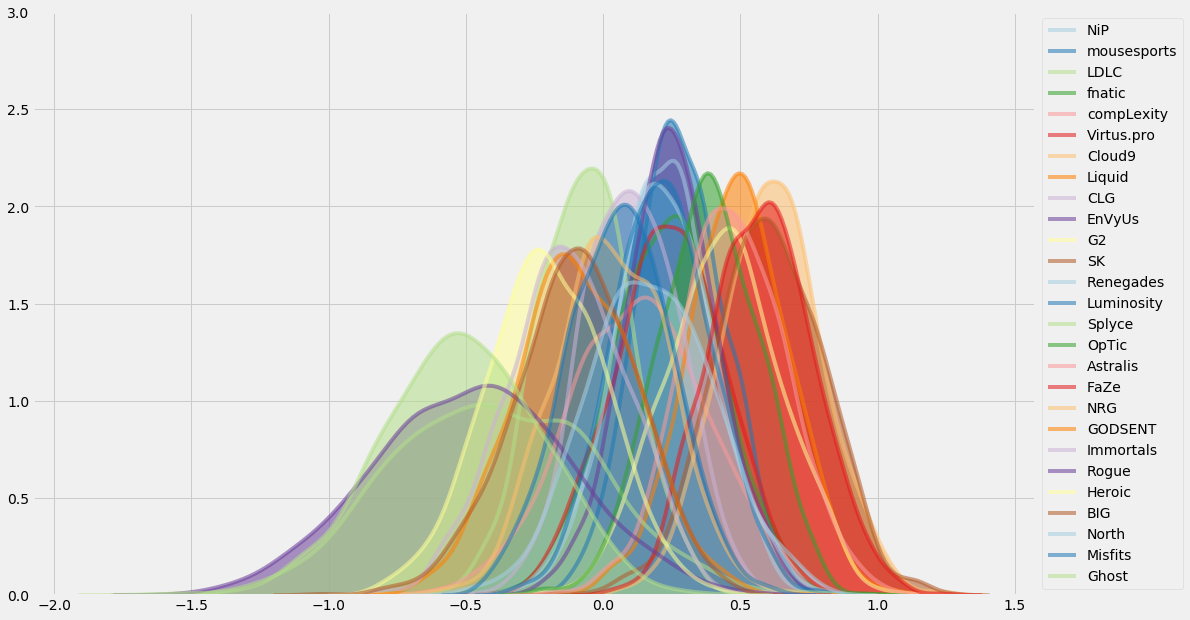

In [31]:
team_names = h_teams.loc[teams]
filt = team_names[team_names.Name.isin(FILTER_TEAMS[EVENT_SET])]
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,3.0)
[sns.kdeplot(ap_trace['rating_%s'%max(obs_period-1)][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

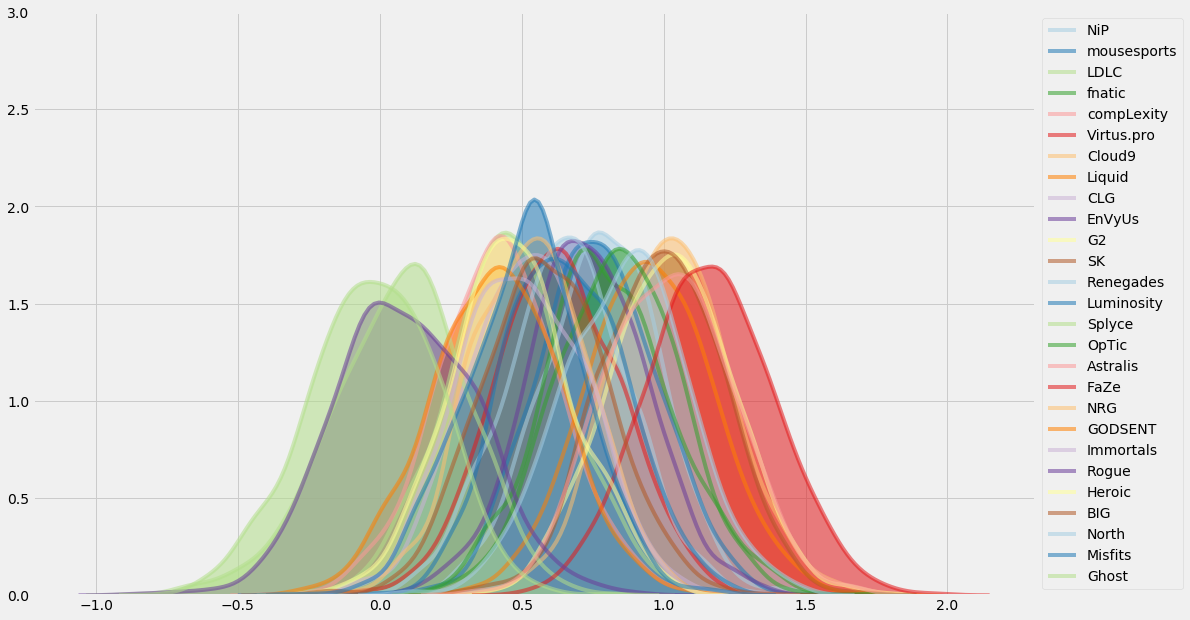

In [23]:
f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,3.0)
[sns.kdeplot(trace['rating_%s'%max(obs_period)][:,tmap[i]], shade=True, alpha=0.55, legend=True, ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


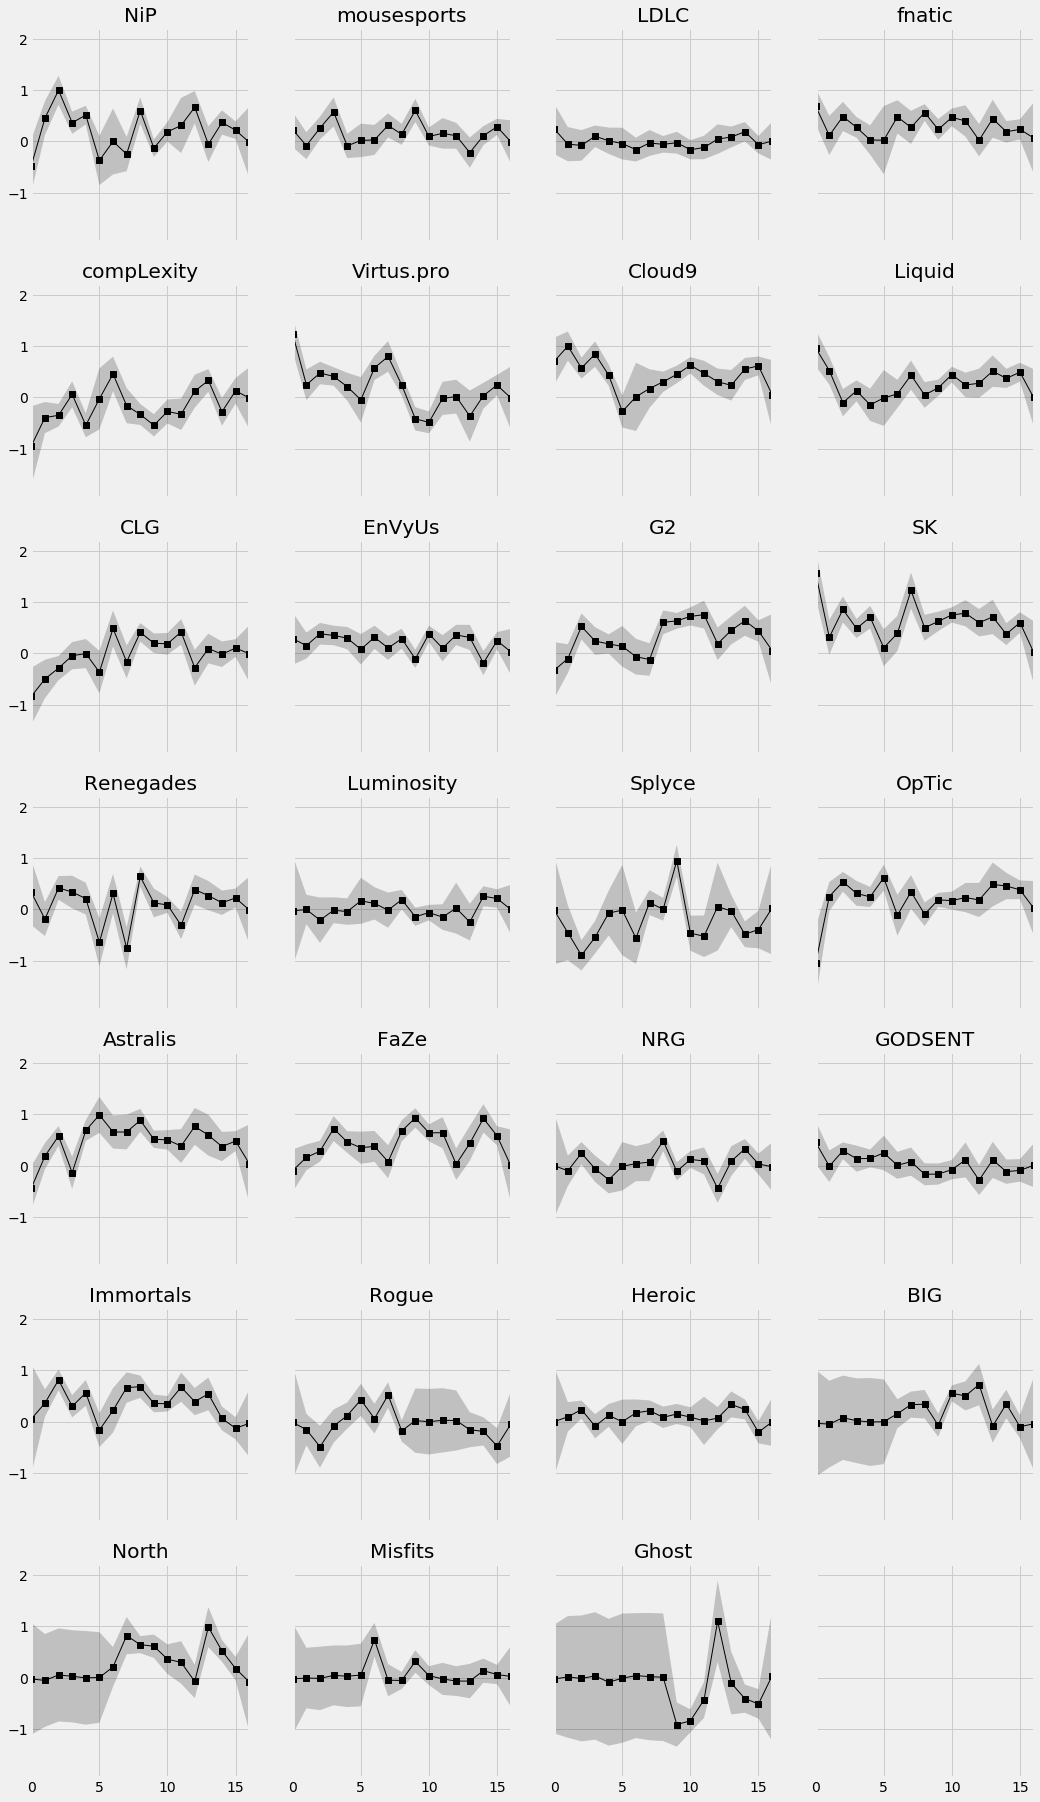

In [32]:
num_rows = int(np.ceil(len(filt)/4))
f, ax = plt.subplots(num_rows, 4, figsize=(16,30), sharex=True, sharey=True)
ax = ax.flatten()
condensed_ratings = {j: np.vstack([ap_trace['rating_'+str(i)][:,tmap[j]] for i in range(n_periods)]).T for j,v in filt.iterrows()}
for i,(j,v) in enumerate(filt.iterrows()):
    ax[i].set_title(v['Name'])
    sns.tsplot(condensed_ratings[j], color='black', ci='sd', ax=ax[i], marker='s', linewidth=1)

In [18]:
a = pd.Series({v['Name']: np.percentile(ap_trace['rating_%s'%max(obs_period)][:,tmap[i]], 75) for i,v in filt.iterrows()}).sort_values(ascending=False)
a = pd.Series(np.arange(1,len(filt)+1), a.index)
b = pd.Series({v['Name']: np.percentile(trace['rating_%s'%max(obs_period)][:,tmap[i]], 75) for i,v in filt.iterrows()}).sort_values(ascending=False)
b = pd.Series(np.arange(1,len(filt)+1), b.index)
pd.DataFrame([a,b], index=['approx', 'nuts']).T.sort_values('nuts')

,approx,nuts
FaZe,2,1
SK,3,2
Astralis,5,3
G2,6,4
Cloud9,1,5
Liquid,4,6
North,14,7
fnatic,11,8
OpTic,7,9
mousesports,10,10


# Save Model

In [27]:
EVENT_SET_SAVED = 'eslpl_time'

pm.backends.text.dump('saved_model/'+EVENT_SET_SAVED+'/trace', trace)
np.save('saved_model/'+EVENT_SET_SAVED+'/teams.npy', teams)
np.save('saved_model/'+EVENT_SET_SAVED+'/maps.npy', maps)
np.save('saved_model/'+EVENT_SET_SAVED+'/periods.npy', periods)
np.save('saved_model/'+EVENT_SET_SAVED+'/filter_teams.npy', FILTER_TEAMS[EVENT_SET])

In [7]:
obs[['Date', 'Team 1 ID', 'Team 2 ID', 'winner']].to_csv('data.csv')

## Diagnostics

In [ ]:
with rating_model:
    approx = pm.fit(15000)
    ap_trace = approx.sample(5000)

In [ ]:
print('Gelman Rubin: %s' % pm.diagnostics.gelman_rubin(trace))
print('Effective N: %s' % pm.diagnostics.effective_n(trace))
print('Accept Prob: %.4f' % trace.get_sampler_stats('mean_tree_accept').mean())
print('Percentage of Divergent %.5f' % (trace['diverging'].nonzero()[0].size/float(len(trace))))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281E1CBC588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000281DDB83550>]], dtype=object)

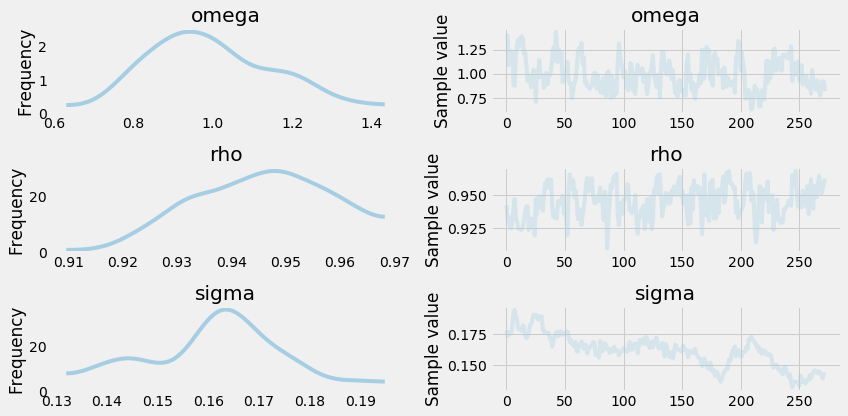

In [46]:
pm.traceplot(trace, varnames=['omega', 'rho', 'sigma'])

In [26]:
rating_model.profile(pm.gradient(rating_model.logpt, rating_model.vars), n=100).summary()

Function profiling
  Message: C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:853
  Time in 100 calls to Function.__call__: 1.704502e-02s
  Time in Function.fn.__call__: 1.203108e-02s (70.584%)
  Time in thunks: 1.102710e-02s (64.694%)
  Total compile time: 2.903986e+01s
    Number of Apply nodes: 119
    Theano Optimizer time: 2.678173e+00s
       Theano validate time: 6.627488e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.456437e+01s
       Import time 1.498575e+00s
       Node make_thunk time 2.455685e+01s
           Node Elemwise{Composite{((i0 * (i1 + i2)) + (i3 * i4) + (i5 * i6) + (i7 * i8) + (i9 * i10) + (i11 * i12) + (i13 * i14) + (i15 * i16) + (i17 * i18) + (i19 * i20) + (i21 * i22))}}[(0, 4)](TensorConstant{-24.999999999999996}, TensorConstant{-0.8}, rho, TensorConstant{16.0}, Sum{acc_dtype=float64}.0, TensorConstant{16.0}, Sum{acc_dtype=float64}.0, TensorConstant{16.0}, Sum{acc_dtype=float64}.0, TensorConsta

In [ ]:
rating_model.profile(rating_model.logpt, n=100).summary()

## Moar Plots

In [ ]:
sns.set_palette('Paired', n_teams)

f, ax = plt.subplots(figsize=(16,10))
ax.set_ylim(0,2.0)
[sns.kdeplot(trace['sigma'][:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=m) for i,m in enumerate(maps)]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
f, axes = plt.subplots(n_maps,1,figsize=(12,34), sharex=True)
for m, ax in enumerate(axes):
    ax.set_title(dict(enumerate(maps))[m])
    ax.set_ylim(0,2.0)
    [sns.kdeplot(trace['rating | map'][:,m,tmap[i]], shade=True, alpha=0.55, legend=False ,
                 ax=ax, label=v['Name']) for i,v in filt.iterrows()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
filt

In [ ]:
i = np.where(teams==7880)
j = np.where(teams==7924)

diff = (trace['rating'][:,j] - trace['rating'][:,i]).flatten()
kappa = 32./(1+np.exp(-1.*trace['alpha']*diff))-16.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
sns.kdeplot(kappa, ax=ax2)
sns.kdeplot(diff, ax=ax1)

## Non-MCMC Model

In [ ]:
def vec2dict(s, n_teams):
    return {
        'mu': np.array(s[:n_teams]),
        'sigma': np.array(s[n_teams:n_teams*2]),
        'beta': s[-1],
    }

def dict2vec(s):
    return s['mu'] + s['sigma'] + [s['beta']]

In [ ]:
skills_0 = dict2vec({
    'mu': [1000]*n_teams,
    'sigma': [300]*n_teams,
    'beta': 50
})

In [ ]:
from scipy.optimize import minimize


def loglike(y,p):
    return -1.*(np.sum(y*np.log(p)+(1-y)*np.log(1.-p)))

def obj(skills):
    s = vec2dict(skills, n_teams)
    mean_diff = s['mu'][obs['Team 1 ID'].map(tmap).values] - s['mu'][obs['Team 2 ID'].map(tmap).values]
    var_diff = s['sigma'][obs['Team 1 ID'].map(tmap).values]**2 + s['sigma'][obs['Team 2 ID'].map(tmap).values]**2 + skills[-1]**2
    p = 1.-norm.cdf(0., loc=mean_diff, scale = np.sqrt(var_diff))
    return loglike((obs['Team 1 ID'] == obs['winner']).values, p)


In [ ]:
obj(skills_0)

In [ ]:
opt_skill = g.x
print(opt_skill)
plots = norm.rvs(opt_skill[:5], opt_skill[5:-1], size=(2000,5))

f, ax = plt.subplots(figsize=(12,8))
[sns.kdeplot(plots[:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in range(5)]